In [1]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
from itertools import product
import warnings
from tabulate import tabulate
import math

warnings.filterwarnings('ignore')
%matplotlib inline

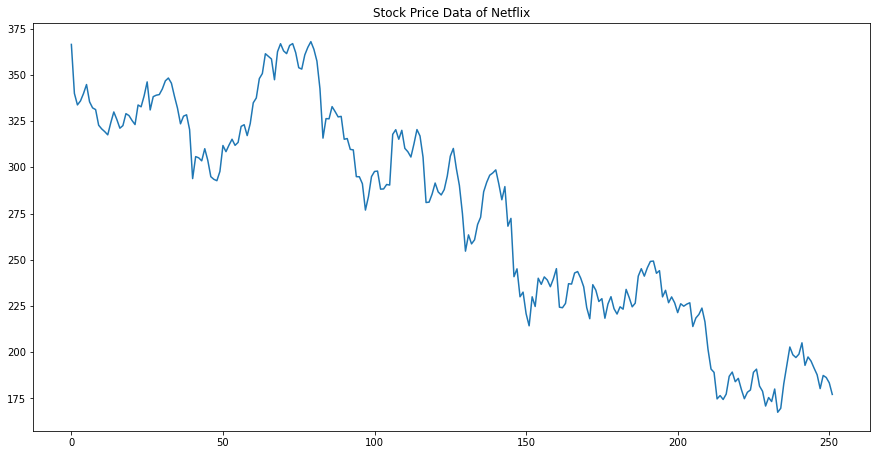

In [73]:
data = pd.read_csv('NFLX Historical Data (1).csv')
plt.figure(figsize=[15, 7.5]);
plt.plot(data['Price'])
plt.title('Stock Price Data of Netflix')
plt.show()

From the plot we can see, that the mean of distribution is obviously not constant, so the data is non-stationary.

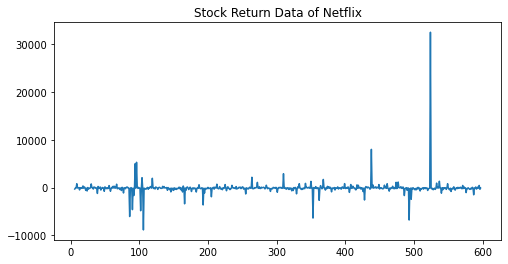

In [46]:
plt.figure(figsize=[8, 4]);
plt.plot(data['Return'])
plt.title('Stock Return Data of Netflix')
plt.show()

In [5]:
daily_volatility = data['Price'].std()

monthly_volatility = math.sqrt(21) * daily_volatility

annual_volatility = math.sqrt(252) * daily_volatility


print(tabulate([['Tesla',daily_volatility,monthly_volatility,annual_volatility]],headers = ['Daily Volatility %', 'Monthly Volatility %', 'Annual Volatility %'],tablefmt = 'fancy_grid',stralign='center',numalign='center',floatfmt=".2f"))


╒═══════╤══════════════════════╤════════════════════════╤═══════════════════════╕
│       │  Daily Volatility %  │  Monthly Volatility %  │  Annual Volatility %  │
╞═══════╪══════════════════════╪════════════════════════╪═══════════════════════╡
│ Tesla │        148.22        │         679.24         │        2352.96        │
╘═══════╧══════════════════════╧════════════════════════╧═══════════════════════╛


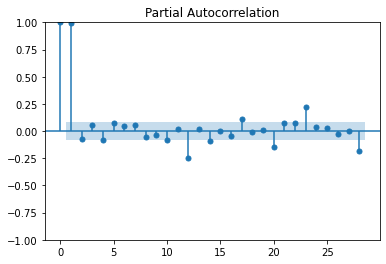

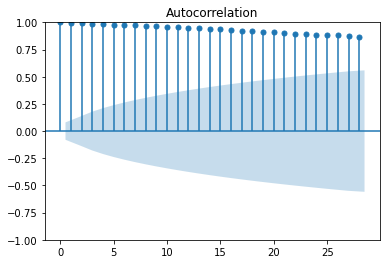

In [6]:
plot_pacf(data['Price']);
plot_acf(data['Price']);

From PACF plot we can see that, we have several significant lags.

In [47]:
ad_fuller_result = adfuller(data['Return'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -24.227796072722466
p-value: 0.0


By applying ADF (Augmented Dickey-Fuller) test, we can see that the p-value is very large so we cannot reject null hypothesis, which means that the data is non-stationary.

In [8]:
data['Price'] = np.log(data['Price'])
data['Price'] = data['Price'].diff()
data = data.drop(data.index[0])

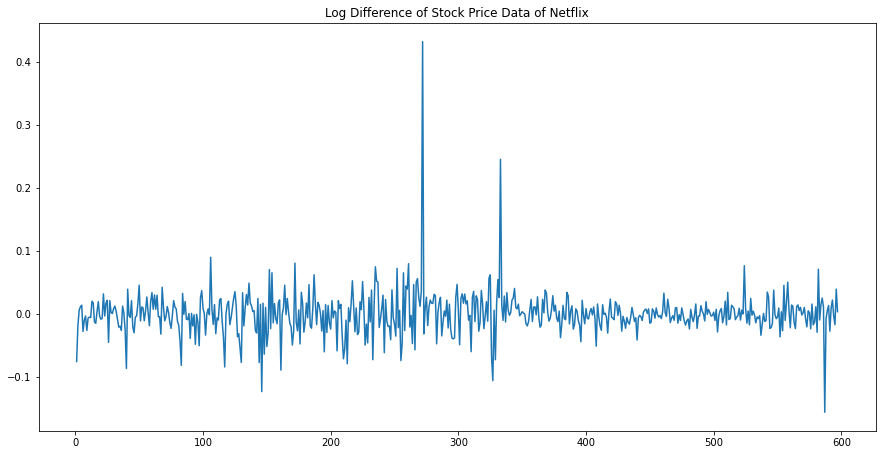

In [10]:
plt.figure(figsize=[15, 7.5]); # Set dimensions for figure
plt.plot(data['Price'])
plt.title("Log Difference of Stock Price Data of Netflix")
plt.show()

After taking the log of stock prices, we can see that from the first glance data looks stationary.

In [11]:
daily_volatility = data['Price'].std()

monthly_volatility = math.sqrt(21) * daily_volatility

annual_volatility = math.sqrt(252) * daily_volatility


print(tabulate([['Tesla',daily_volatility,monthly_volatility,annual_volatility]],headers = ['Daily Volatility %', 'Monthly Volatility %', 'Annual Volatility %'],tablefmt = 'fancy_grid',stralign='center',numalign='center',floatfmt=".2f"))


╒═══════╤══════════════════════╤════════════════════════╤═══════════════════════╕
│       │  Daily Volatility %  │  Monthly Volatility %  │  Annual Volatility %  │
╞═══════╪══════════════════════╪════════════════════════╪═══════════════════════╡
│ Tesla │         0.03         │          0.16          │         0.55          │
╘═══════╧══════════════════════╧════════════════════════╧═══════════════════════╛


In [12]:
ad_fuller_result = adfuller(data['Price'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -24.080744724471877
p-value: 0.0


Again by applying ADF (Augmented Dickey-Fuller) test, we can see that the p-value is 0 so we can reject null hypothesis, which means that the data is stationary already.

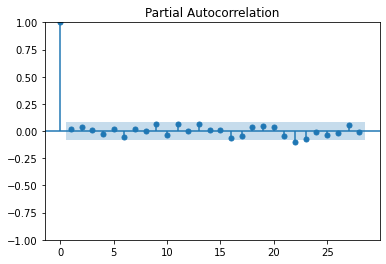

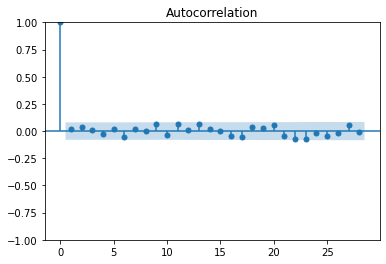

In [13]:
plot_pacf(data['Price']);
plot_acf(data['Price']);

Both from PACF and ACF plots we can see that there are no any significant lags for log data.

In [14]:
def optimize_SARIMA(parameters_list, d, D, s, exog):
    """
        Return dataframe with parameters, corresponding AIC and SSE
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
        exog - the exogenous variable
    """
    
    results = []
    
    for param in tqdm_notebook(parameters_list):
        try: 
            model = SARIMAX(exog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        results.append([param, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df


In [15]:
p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 1
Q = range(0, 4, 1)
s = 4
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(len(parameters_list))

256


In [16]:
result_df = optimize_SARIMA(parameters_list, 1, 1, 4, data['Price'][:-test_size])
result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q)x(P,Q)",AIC
0,"(0, 1, 0, 1)",-2264.620114
1,"(1, 2, 0, 1)",-2264.008586
2,"(0, 1, 1, 1)",-2263.952856
3,"(0, 2, 0, 1)",-2263.034534
4,"(1, 1, 0, 1)",-2262.709858
...,...,...
251,"(2, 0, 0, 0)",-1709.872000
252,"(0, 0, 2, 0)",-1699.532460
253,"(1, 0, 0, 0)",-1654.375261
254,"(0, 0, 1, 0)",-1632.839390


In [66]:
best_model = SARIMAX(data['Price'][:-test_size], order=(0, 1, 1), seasonal_order=(0, 1, 1, 4)).fit(dis=-1)
print(best_model.summary())

                                     SARIMAX Results                                     
Dep. Variable:                             Price   No. Observations:                  412
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 4)   Log Likelihood                 726.484
Date:                           Fri, 19 May 2023   AIC                          -1446.967
Time:                                   06:34:04   BIC                          -1434.941
Sample:                                        0   HQIC                         -1442.208
                                           - 412                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9967      0.055    -18.161      0.000      -1.104      -0.889
ma.S.L4       -0.9945      0.102     -9.722

AIC (Akaike Information Criterion) is used for determining the best parameters of SARIMA model, and from the left it can be concluded that SARIMA(0, 1, 1)x(0, 1, 1, 4) has the lowest AIC, so it’s the best model (seasonal length in data is taken to be 4). From the model results in the right, we can see very low AIC and BIC scores that indicate good fitted model, and also all coefficients are significant based on 0 p-values with 97.5% confidence interval. 

In [64]:
data['Price'][:-test_size]

6     -0.027465
7     -0.009827
8     -0.002804
9     -0.025844
10    -0.006153
         ...   
413    0.014943
414   -0.000422
415    0.001468
416   -0.004409
417   -0.030094
Name: Price, Length: 412, dtype: float64

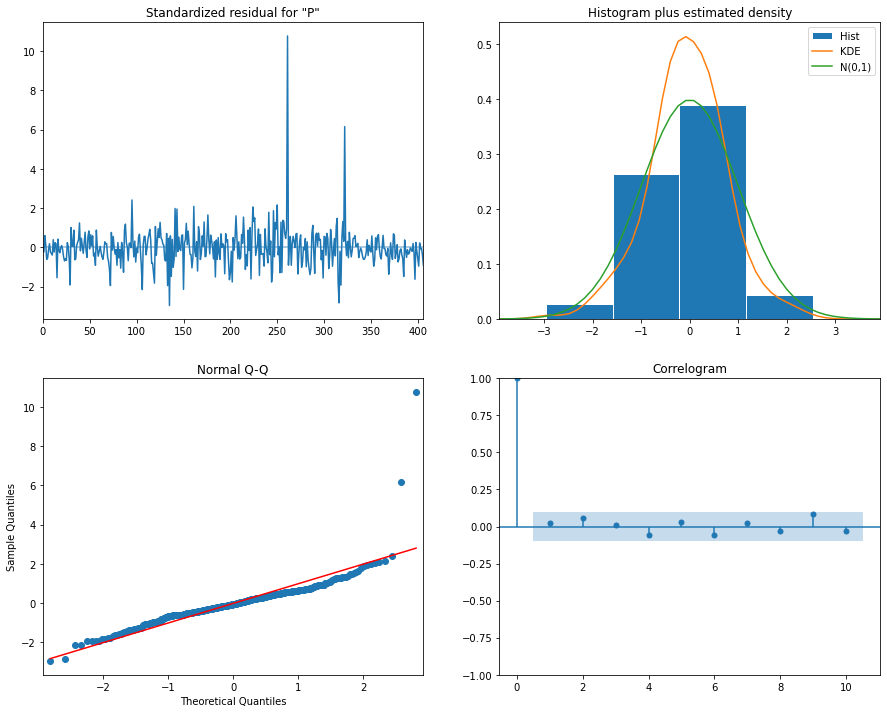

In [67]:
best_model.plot_diagnostics(figsize=(15,12));

From the model diagnostics, if we look at the QQ-plot, we can see that the line is almost straight which means no systematic deviation from normality. And if we look ar the correlogram, there are no significant lags so there is no autocorrelation in the residuals.

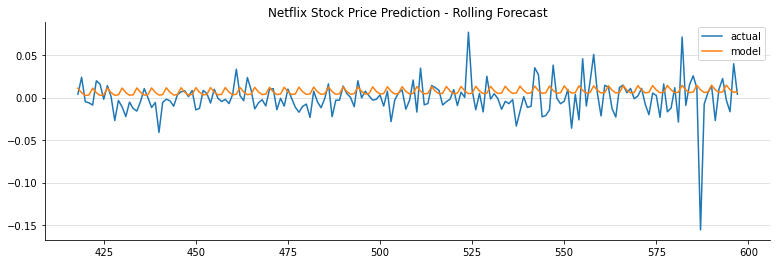

In [68]:
# data['arima_model'] = best_model.fittedvalues
# data['arima_model'][:4+1] = np.NaN
# forecast = best_model.predict(start=data.shape[0], end=data.shape[0] + 20)
# forecast = data['arima_model'].append(forecast)
# plt.figure(figsize=(15, 7.5))
# plt.plot(forecast, color='r', label='model')
# plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
# plt.plot(data['Price'], label='actual')
# plt.legend()
# plt.show()

forecast = best_model.predict(start=418, end=597)
fig,ax = plt.subplots(figsize=(13,4))
ax.grid(which="major", axis='y', color='#758D99', alpha=0.3, zorder=1)
ax.spines[['top','right']].set_visible(False)
plt.plot(data['Price'][-test_size:])
plt.plot(forecast)
plt.title('Netflix Stock Price Prediction - Rolling Forecast')
plt.legend(['actual', 'model'])
plt.show()

In [53]:
from arch import arch_model
from arch.__future__ import reindexing

garch_model = arch_model(data['Price'], p = 1, q = 1,
                      mean = 'constant', vol = 'GARCH', dist = 'normal')

gm_result = garch_model.fit(disp='off')
print(gm_result.params)

print('\n')

gm_forecast = gm_result.forecast(horizon = 5)
print(gm_forecast.variance[-1:])

mu         -0.001240
omega       0.000025
alpha[1]    0.100106
beta[1]     0.879896
Name: params, dtype: float64


          h.1       h.2       h.3       h.4       h.5
597  0.001259  0.001259  0.001259  0.001258  0.001258


In [26]:
data['Change %']

1       1.86%
2      -0.64%
3      -1.18%
4      -1.41%
5       2.78%
        ...  
593     0.30%
594     1.68%
595    -3.90%
596    -0.39%
597    -3.30%
Name: Change %, Length: 597, dtype: object

Text(0.5, 1.0, 'Predictions')

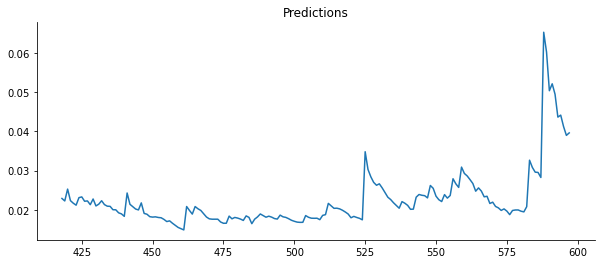

In [54]:
import pandas as pd

rolling_predictions = []
test_size = 180

for i in range(test_size):
    train = data['Price'][:-(test_size-i)]
    model = arch_model(train, p=1, q=1, mean = 'constant', vol = 'GARCH', dist = 'normal')
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))
    
rolling_predictions = pd.Series(rolling_predictions, index=data['Price'].index[-test_size:])

fig,ax = plt.subplots(figsize=(10,4))
ax.spines[['top','right']].set_visible(False)
plt.plot(rolling_predictions)
plt.title('Predictions')


In [70]:
model = arch_model(data['Price'], p=1, q=1, mean = 'constant', vol = 'GARCH', dist = 'normal')
model_fit = model.fit(disp='off')
pred = model_fit.forecast(horizon=1)
# rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

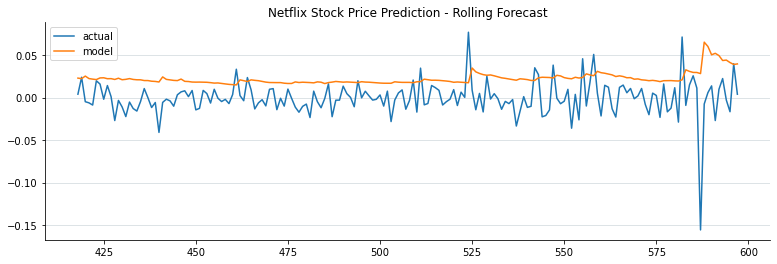

In [60]:
fig,ax = plt.subplots(figsize=(13,4))
ax.grid(which="major", axis='y', color='#758D99', alpha=0.3, zorder=1)
ax.spines[['top','right']].set_visible(False)
plt.plot(data['Price'][-test_size:])
plt.plot(rolling_predictions)
plt.title('Netflix Stock Price Prediction - Rolling Forecast')
plt.legend(['actual', 'model'])


# plt.figure(figsize=(15, 7.5))
# plt.plot(rolling_predictions, color='r', label='model')
# plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
# plt.plot(data['Price'], label='actual')
# plt.legend()
# plt.show()


In [49]:
data.shape[0]

598

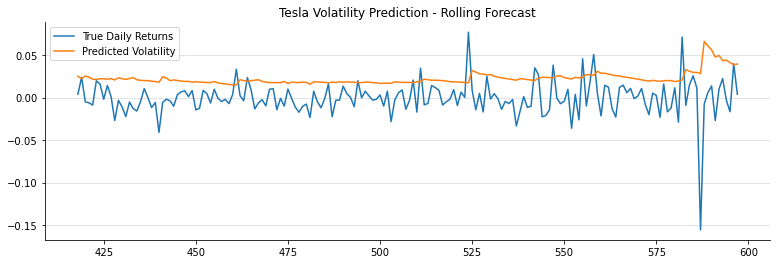

In [73]:
fig,ax = plt.subplots(figsize=(13,4))
ax.grid(which="major", axis='y', color='#758D99', alpha=0.3, zorder=1)
ax.spines[['top','right']].set_visible(False)
plt.plot(data['Price'][-test_size:])
plt.plot(rolling_predictions)
plt.title('Netflix Stock Price Prediction - Rolling Forecast')
plt.legend(['True Daily Returns', 'Predicted Volatility'])

In [71]:
print(model_fit.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Price   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                1226.68
Distribution:                  Normal   AIC:                          -2445.36
Method:            Maximum Likelihood   BIC:                          -2427.82
                                        No. Observations:                  592
Date:                Fri, May 19 2023   Df Residuals:                      591
Time:                        06:38:45   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -1.2401e-03  1.182e-03     -1.049      0.

The value of alpha is small, so the past volatility has weaker effect on current volatility. On the other hand, the value of beta is high, indicating fast adjustment of the conditional variance to past volatility shocks. The AIC is bigger than the AIC of SARIMA model, but the BIC is smaller. All the coefficients in Volatility Model have very small p-values so all of them are significant with 95% confidence interval. mu’s p-value is 0.2, meaning we can’t reject null hypothesis so it’s not significant.

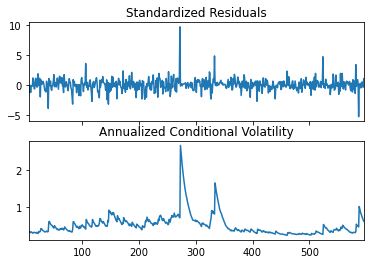

In [57]:
# Plot the standardized residuals
fig = model_fit.plot(annualize='D')
plt.show()